In [4]:
%load_ext autoreload
%autoreload 3
from data_functions import get_dataset
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler as SRS
from train_utils import SubsetSampler as SS
from sklearn.model_selection import train_test_split as TTS
import torch
import random
import numpy as np
torch.use_deterministic_algorithms(True) # reproducibility

STATE = "SP"
WEEKS = False
TRIANGLE = True
PAST_UNITS = 40
MAX_DELAY = 40
BATCH_SIZE = 64
RANDOM_SPLIT = False
SEED = 1234
DEVICE = "mps"

dataset = get_dataset(weeks=WEEKS, triangle=TRIANGLE, past_units=PAST_UNITS, max_delay=MAX_DELAY, state=STATE)
n_obs_40pu = len(dataset) # 2922 total dates, -39-39 for past_units and max_delay ->2844
print(n_obs_40pu)
## Define train and test indices
if RANDOM_SPLIT:
    all_idcs = range(dataset.__len__())
    train_idcs, test_idcs = TTS(all_idcs, test_size=0.25, shuffle=True, random_state=SEED)
    train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=SEED)
    #train_idcs, test_idcs = [*range(600), *range(950, dataset.__len__())], [*range(600, 950)]
    VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
else:
    if WEEKS: # could also do random split, for now last indices as test
        train_idcs, test_idcs = range(300), range(300, dataset.__len__())
        TEST_BATCH_SIZE = dataset.__len__() - 300
    else: 
        train_idcs, test_idcs = range(2133), range(2133, dataset.__len__()) # 2844 total obs - 711 test, still 25% even without random split
        train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=SEED)
        VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
        
## Define generator so sampling during training is deterministic and reproducible
g = torch.Generator()
g.manual_seed(SEED)
train_sampler, val_sampler, test_sampler = SRS(train_idcs, generator=g), SRS(val_idcs), SS(test_idcs)
train_loader, val_loader, test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler), DataLoader(dataset, batch_size=VAL_BATCH_SIZE, sampler=val_sampler, shuffle=False), DataLoader(dataset, batch_size=TEST_BATCH_SIZE, sampler=test_sampler, shuffle=False)

## Function to reset the sampler so each training run uses same order of observations for reproducibility
## Possible to define s.t. returns train_loader, but bc in notebook, possible to define globally
def regen_data():
    g = torch.Generator()
    g.manual_seed(SEED)
    global train_loader
    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=SRS(train_idcs, generator=g))

def set_seeds(SEED):
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

set_seeds(SEED)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/NowcastPNN/src/data_functions.py:88: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


2922 2013-01-01 00:00:00 2020-12-31 00:00:00
2844


In [5]:
import numpy as np
from torch import nn

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time, device = "mps"):
        ''' Forward call of embedding module

        Args:
        time [torch.Tensor]: tensor of timesteps in batch

        Returns:
        PE [torch.Tensor]: embedding matrix        
        '''
        PE = torch.zeros(time.shape[0], self.dim, device=device)
        # Calculate the positional encodings
        for pos in range(time.shape[0]): 
            for i in range(self.dim):
                if i % 2 == 0: # should be 2*i and 2*i-1 as positions
                    PE[pos, i] = np.sin(np.exp(np.log(pos+1e-3) - (2 * i) / self.dim * np.log(10000))) # Add noise to avoid zero-division
                else: # Odd dimensions
                    PE[pos, i] = np.cos(np.exp(np.log(pos+1e-3) - (2 * i) / self.dim * np.log(10000)))
        # time contains all indices as slices
        return PE

class EarlyStopper:
    """ Class implementing early stopping. Theoretically, PyTorch lightning could be used, but this might be more rubust.
    
    As seen e.g. in https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch and adapted to include 
    restoration of best weights.
    """
    def __init__(self, patience = 30):
        self.patience = patience
        self.counter = 0
        self.min_loss = float('inf')

    def early_stop(self, val_loss, model):
        if val_loss < self.min_loss:
            self.min_loss = val_loss
            self.counter = 0
            ## Save best weights
            torch.save(model.state_dict(), f"./weights/weights-{PAST_UNITS}-{MAX_DELAY}-{'week' if WEEKS else 'day'}-{('tri' if TRIANGLE else 'sum')}-{STATE}")
        elif val_loss > self.min_loss:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
    def get_count(self):
        return self.counter

In [39]:
import torch.nn as nn
import torch
from NegativeBinomial import NegBin as NB
from torch.distributions import Poisson as Poi
set_seeds(SEED)

## For matrix-like (two-dimensional) input data
class PNNTriangleDaily(nn.Module):
    def __init__(self, past_units = 40, max_delay = 40, hidden_units = [16, 8], conv_channels = [16, 1]):
        super().__init__()
        self.past_units = past_units
        self.max_delay = max_delay
        self.final_dim = past_units# * (2**len(conv_channels))
        self.conv1 = nn.Conv1d(self.max_delay, conv_channels[0], kernel_size=7, padding="same")
        self.conv2 = nn.Conv1d(conv_channels[0], conv_channels[1], kernel_size=7, padding="same")
        #self.conv3 = nn.Conv1d(conv_channels[1], conv_channels[2], kernel_size=7, padding="same")
        #self.conv4 = nn.Conv1d(conv_channels[2], conv_channels[3], kernel_size=7, padding="same")
        self.fc1 = nn.Linear(self.past_units, self.past_units)#, nn.Linear(self.past_units, self.past_units)
        self.fc3, self.fc4 = nn.Linear(self.final_dim, hidden_units[0]), nn.Linear(hidden_units[0], hidden_units[1])#, nn.Linear(hidden_units[1], hidden_units[2])
        #self.fc5 = nn.Linear(hidden_units[1], hidden_units[2])
        self.fcnb = nn.Linear(hidden_units[-1], 2)
        #self.fcpoi = nn.Linear(hidden_units[-1], 1)
        self.const = 10000 # if not normalized, take constant out

        self.bnorm1, self.bnorm2 = nn.BatchNorm1d(num_features=self.max_delay), nn.BatchNorm1d(num_features=conv_channels[0])#, nn.BatchNorm1d(num_features=conv_channels[1])#, nn.BatchNorm1d(num_features=conv_channels[2])
        #self.bnorm3 = nn.BatchNorm1d(num_features=conv_channels[1])
        self.bnorm5, self.bnorm6  = nn.BatchNorm1d(num_features=self.final_dim), nn.BatchNorm1d(num_features=hidden_units[0])#, nn.BatchNorm1d(num_features=hidden_units[2])
        #self.bnorm7 = nn.BatchNorm1d(num_features=hidden_units[1])
        self.bnorm_final = nn.BatchNorm1d(num_features=hidden_units[-1]) #hidden_units[1]/self.past_units for single model
        self.attn1 = nn.MultiheadAttention(embed_dim=self.max_delay, num_heads=1, batch_first=True)
        self.drop1, self.drop2 = nn.Dropout(0.3), nn.Dropout(0.1) # optimal 0.15, 0.1 for random split 
        self.softplus = nn.Softplus()
        self.act = nn.SiLU()
    
    def forward(self, x): ## Feed forward function, takes input of shape [batch, past_units, max_delay]
        #x = x.permute(0, 2, 1) # [batch, past_units, max_delay] -> [batch, max_delay, past_units]
        x = x.float()
        ## Attention Block ##
        x_add = x.clone()
        x = self.attn1(x, x, x, need_weights = False)[0]
        x = self.act(self.fc1(x.permute(0,2,1)))
        x = x.permute(0,2,1) + x_add

        ## Convolutional Block ##
        x = x.permute(0, 2, 1) # [batch, past_units, max_delay] -> [batch, max_delay, past_units]
        x = self.act(self.conv1(self.bnorm1(x)))
        x = self.act(self.conv2(self.bnorm2(x)))
        #x = self.act(self.conv3(self.bnorm3(x)))
        #x = self.act(self.conv4(self.bnorm4(x)))
        x = torch.squeeze(x)
        
        ## Fully Connected Block ##
        x = self.drop1(x)
        x = self.act(self.fc3(self.bnorm5(x)))
        x = self.drop2(x)
        x = self.act(self.fc4(self.bnorm6(x)))
        #x = self.drop3(x)
        #x = self.act(self.fc5(self.bnorm7(x)))

        
        x = self.fcnb(self.bnorm_final(x))
        dist = NB(lbda = self.const*self.softplus(x[:, 0]), phi = (self.const**2)*self.softplus(x[:, 1])+1e-5)
        """
        x = self.fcpoi(self.bnorm_final(x))
        dist = Poi(rate=self.const*self.softplus(x)+1e-5)
        """
        return torch.distributions.Independent(dist, reinterpreted_batch_ndims=1)

## For summed (one-dimensional) input data
class PNNSumDaily(nn.Module):
    def __init__(self, past_units = 30, max_delay = 40, hidden_units = [12, 6]):
        super().__init__()
        self.past_units = past_units
        self.max_delay = max_delay
        self.final_dim = past_units# * (2**len(conv_channels))
        #self.conv3 = nn.Conv1d(conv_channels[1], conv_channels[2], kernel_size=7, padding="same")
        #self.conv4 = nn.Conv1d(conv_channels[2], conv_channels[3], kernel_size=7, padding="same")
        self.fc1 = nn.Linear(self.past_units, self.past_units)#, nn.Linear(self.past_units, self.past_units)
        self.fc3, self.fc4 = nn.Linear(self.final_dim, hidden_units[0]), nn.Linear(hidden_units[0], hidden_units[1])#, nn.Linear(hidden_units[1], hidden_units[2])
        #self.fc5 = nn.Linear(hidden_units[1], hidden_units[2])
        self.fcnb = nn.Linear(hidden_units[-1], 2)
        #self.fcpoi = nn.Linear(hidden_units[1], 1)
        self.const = 10000

        self.bnorm5, self.bnorm6  = nn.BatchNorm1d(num_features=self.final_dim), nn.BatchNorm1d(num_features=hidden_units[0])#, nn.BatchNorm1d(num_features=hidden_units[2])
        #self.bnorm7 = nn.BatchNorm1d(num_features=hidden_units[1])
        self.bnorm_final = nn.BatchNorm1d(num_features=hidden_units[-1]) #hidden_units[1]/self.past_units for single model
        self.attn1 = nn.MultiheadAttention(embed_dim=1, num_heads=1, batch_first=True)
        self.drop1, self.drop2 = nn.Dropout(0.1), nn.Dropout(0.1)#, nn.Dropout(0.1) # 0.4, 0.4, 0.2 great performance, but too wide CIs
        self.softplus = nn.Softplus()
        self.act = nn.SiLU()
    
    def forward(self, x): # Feed forward function, takes input of shape [batch, past_units, max_delay]
        ## Attention Block ##
        x = torch.unsqueeze(x, -1)
        x_add = x.clone()
        x = self.attn1(x, x, x, need_weights = False)[0]
        x = self.act(self.fc1(x.permute(0, 2, 1)))
        x = x.permute(0,2,1) + x_add
        x = torch.squeeze(x) # remove lone dimension of 1 for FC layers

        ## Fully Connected Block ##
        x = self.drop1(x)
        x = self.act(self.fc3(self.bnorm5(x)))
        x = self.drop2(x)
        x = self.act(self.fc4(self.bnorm6(x)))
        #x = self.drop3(x)
        #x = self.act(self.fc5(self.bnorm7(x)))
        #x = self.drop3(x)
        x = self.fcnb(self.bnorm_final(x))
        dist = NB(lbda = self.const*self.softplus(x[:, 0]), phi = (self.const**2)*self.softplus(x[:, 1])+1e-5)
        #x = self.fcpoi(self.bnorm7(x))
        #dist = torch.distributions.Poisson(rate=self.const*self.softplus(x))
        return torch.distributions.Independent(dist, reinterpreted_batch_ndims=1)


In [40]:
%reload_ext autoreload
%autoreload 3
from train_utils import train, EarlyStopper
set_seeds(SEED)

regen_data() # reset samplers so each training run is reproducible
early_stopper = EarlyStopper(patience=30, past_units=PAST_UNITS, max_delay=MAX_DELAY, weeks=WEEKS, state="SP", future_obs=0, triangle=TRIANGLE)
nowcast_pnn = PNNTriangleDaily(past_units=PAST_UNITS, max_delay=MAX_DELAY)
#nowcast_pnn = PNNSumDaily(past_units=PAST_UNITS, max_delay=MAX_DELAY)
train(nowcast_pnn, num_epochs=200, train_loader=train_loader, val_loader=val_loader, early_stopper=early_stopper, loss_fct="nll", device = DEVICE)
## Load best set of weights on test/validation set
nowcast_pnn.load_state_dict(torch.load(f"./weights/weights-{PAST_UNITS}-{MAX_DELAY}-{'week' if WEEKS else 'day'}-{('tri' if TRIANGLE else 'sum')}-fut0-{STATE}"))

Epoch 1 - Train loss: 2.62e+05 - Val loss: 2.02e+06 - ES count: 0
Epoch 2 - Train loss: 2.54e+05 - Val loss: 1.98e+06 - ES count: 0
Epoch 3 - Train loss: 2.49e+05 - Val loss: 1.98e+06 - ES count: 1
Epoch 4 - Train loss: 2.45e+05 - Val loss: 1.85e+06 - ES count: 0
Epoch 5 - Train loss: 2.41e+05 - Val loss: 1.87e+06 - ES count: 1
Epoch 6 - Train loss: 2.38e+05 - Val loss: 1.88e+06 - ES count: 2
Epoch 7 - Train loss: 2.34e+05 - Val loss: 1.7e+06 - ES count: 0
Epoch 8 - Train loss: 2.29e+05 - Val loss: 1.83e+06 - ES count: 1
Epoch 9 - Train loss: 2.26e+05 - Val loss: 1.8e+06 - ES count: 2
Epoch 10 - Train loss: 2.21e+05 - Val loss: 1.78e+06 - ES count: 3
Epoch 11 - Train loss: 2.15e+05 - Val loss: 1.6e+06 - ES count: 0
Epoch 12 - Train loss: 2.1e+05 - Val loss: 1.61e+06 - ES count: 1
Epoch 13 - Train loss: 2.04e+05 - Val loss: 1.52e+06 - ES count: 0
Epoch 14 - Train loss: 1.98e+05 - Val loss: 1.48e+06 - ES count: 0
Epoch 15 - Train loss: 1.91e+05 - Val loss: 1.46e+06 - ES count: 0
Epoch 16

<All keys matched successfully>

In [43]:
from metrics import pnn_PIs, evaluate_PIs
set_seeds(SEED)
## Write function to generate interval dict, and safe it if desired, then pass to standard evaluate_PI
levels_pnn = pnn_PIs(nowcast_pnn, test_loader, random_split = RANDOM_SPLIT, save=True) # can save if good scores and architecture to use for comparisons with others
_ = evaluate_PIs(levels_pnn, test_loader, return_coverages=False, return_is_decomposed=False)

AttributeError: 'ReportingDataset' object has no attribute 'dow'

In [16]:
from metrics import evaluate_model
set_seeds(SEED)
evaluate_model(nowcast_pnn, dataset, test_loader=test_loader, test_batch_size=TEST_BATCH_SIZE)

711
Actual coverage per level | 5%: 0.14 | 10%: 0.14 | 25%: 1.13 | 50%: 2.81 | 75%: 5.63 | 90%: 9.7 | 95%: 14.91 |
PICA: 0.45077355836849503
CWC: 0.29227875389898755
WIS: 1144.949493032765
IS: 3155.870297256267
IS: under = 0.23296873219147268 | spread = 251.04802591922842 | over = 2904.5893026048466 | total = 3155.870297256267


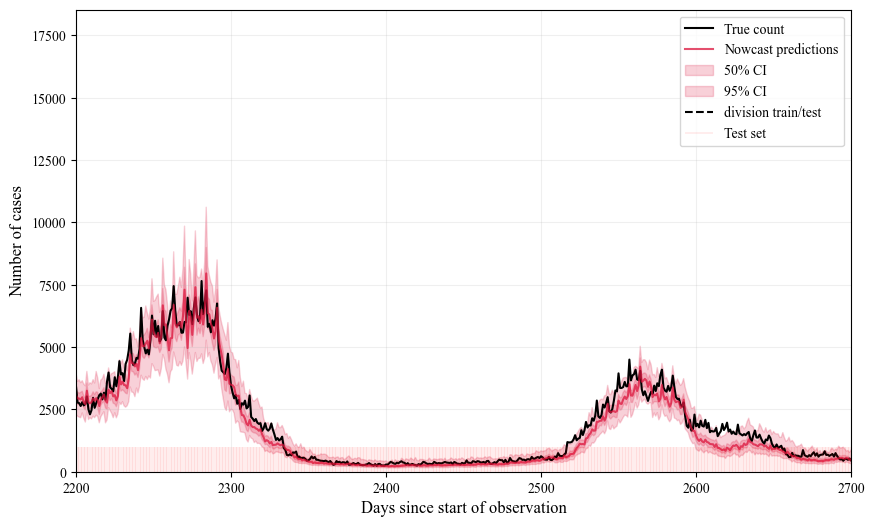

In [42]:
%reload_ext autoreload
%autoreload 3
from plotting import plot_entire_confints
set_seeds(SEED) # biggest outbreak 600, 900
plot_entire_confints(dataset, nowcast_pnn, weeks = WEEKS, random_split = RANDOM_SPLIT, xlims = [2200, 2700], test_idcs=test_idcs)

### Save intervals_dict so can be compared along the predictions of all other models

## Structure of daily data

Just have target col and summed past observations as features as input, just sum down triangle and reconvert to cols for each point

In [244]:
import pandas as pd
from epiweeks import Week, Year
"""test_df_dates = pd.DataFrame({"DT_SIN_PRI": ["1980-01-01", "1980-01-03", "1980-01-05", "1980-01-06"], "delay_0": [1, 2, 3, 4], "delay_1": [1, 2, 3, 4], "delay_2": [1, 2, 3, 4], "delay_3": [1, 2, 3, 4]})

test_df_dates['DT_SIN_PRI'] = pd.to_datetime(test_df_dates['DT_SIN_PRI'])
    
# Find the date range in the DataFrame
start_date = test_df_dates['DT_SIN_PRI'].min()
end_date = test_df_dates['DT_SIN_PRI'].max()

# Create a new DataFrame with a continuous range of dates
date_range_df = pd.DataFrame({'DT_SIN_PRI': pd.date_range(start=start_date, end=end_date)})

# Merge the original DataFrame with the date range DataFrame, filling missing values with 0
filled_df = pd.merge(date_range_df, test_df_dates, how='left', on='DT_SIN_PRI')

# Replace NaN values in numeric columns with 0
for col in filled_df.columns.drop('DT_SIN_PRI'):
    filled_df[col] = filled_df[col].fillna(0)

filled_df"""

def epiweek_df_start_end(start: str, end: str):
    year_start, wk_start = int(start[0:4]), int(start[4:-1])
    year_end, wk_end = int(start[0:4]), int(start[4:-1])

    out = [start]
    cur_week = wk_start
    for y in range(year_start, year_end+1):
        for w in range(cur_week, sum(1 for _ in Year(y).iterweeks())+1): # some epiweeks have 53 weeks, need to account
            if y == year_end and cur_week > wk_end:
                return pd.DataFrame({})
            out.append(f"{y}{w}")
        cur_week = 1


test_week_epi = Week.fromdate(pd.to_datetime("1980-01-01"))
test_week_epi.cdcformat()

'198001'

In [7]:
test_df = get_dataset(weeks=WEEKS, triangle=TRIANGLE, past_units=PAST_UNITS, max_delay=MAX_DELAY, state=STATE, return_df = True)

/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/Thesis/src/data_functions.py:85: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


2922 2013-01-01 00:00:00 2020-12-31 00:00:00


In [265]:
test_df

,delay_0,delay_1,delay_2,delay_3,delay_4,delay_5,delay_6,delay_7,delay_8,delay_9,...,delay_30,delay_31,delay_32,delay_33,delay_34,delay_35,delay_36,delay_37,delay_38,delay_39
0,12.0,57.0,58.0,74.0,22.0,6.0,62.0,45.0,31.0,17.0,...,2.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,19.0,66.0,56.0,24.0,16.0,65.0,47.0,48.0,28.0,15.0,...,1.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,0.0,0.0
2,29.0,79.0,28.0,20.0,73.0,47.0,52.0,43.0,23.0,1.0,...,0.0,0.0,3.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0
3,34.0,54.0,23.0,92.0,53.0,48.0,50.0,41.0,3.0,2.0,...,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,28.0,36.0,68.0,61.0,59.0,44.0,46.0,3.0,2.0,30.0,...,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,14.0,43.0,50.0,26.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2918,31.0,65.0,34.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2919,16.0,35.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2920,13.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Works perfectly, every date is included. Because it is Sao Paulo, probably anyways, but this function makes sure

## Investigate divergence

Take specific day (e.g. 750) to make masking and then plot true rowsum vs masked row sum

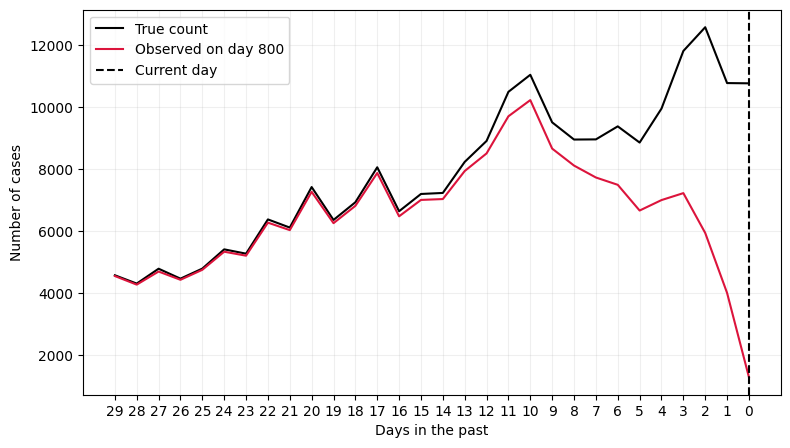

In [8]:
from plotting import plot_distance_true_observed
plot_distance_true_observed(test_df, 800, future_units=0)

In [4]:

import pandas as pd
dengdf = pd.read_csv(f"../data/derived/DENG{STATE}.csv", index_col=0)
date_format = "%Y-%m-%d"
dengdf['DT_NOTIFIC'] = pd.to_datetime(dengdf['DT_NOTIFIC'], format=date_format)
dengdf['DT_SIN_PRI'] = pd.to_datetime(dengdf['DT_SIN_PRI'], format=date_format)

## Filter to only take rows with onset after 2012 (2013-1, others assumed to be faulty data)
dengdf = dengdf.loc[((dengdf["DT_SIN_PRI"].dt.year > 2012) & (dengdf["DT_SIN_PRI"].dt.year < 2021) & (dengdf["DT_NOTIFIC"].dt.year > 2012) & (dengdf["DT_NOTIFIC"].dt.year < 2021))]


/var/folders/xr/mqd4g8995xqfhcvcyvr2smdc0000gn/T/ipykernel_1527/3349867799.py:2: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(f"../data/derived/DENG{STATE}.csv", index_col=0)


In [5]:
len(dengdf[dengdf["DT_SIN_PRI"] == "2015-03-12"])

10917

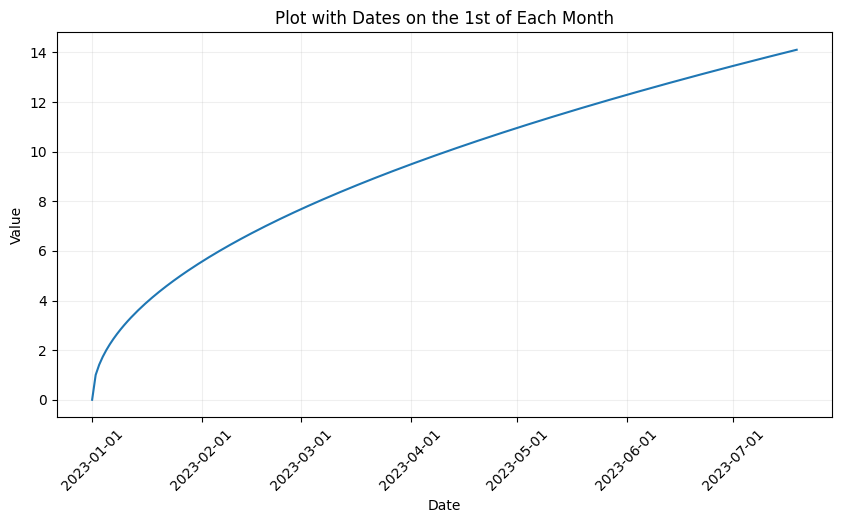

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

def days_to_date(start_date, num_days, past_units = 1):
    """
    Converts number of days since start_date to the corresponding date.
    
    Args:
    start_date (str): The start date in 'YYYY-MM-DD' format.
    num_days (int): Number of days from the start date.
    
    Returns:
    datetime: The corresponding date.
    """
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    return start_date + timedelta(days=num_days+past_units-1)

def plot_with_first_of_month(start_date, num_days_list, values):
    """
    Plots values with dates corresponding to the number of days since start_date.
    Only the 1st of each month is shown on the x-axis.
    
    Args:
    start_date (str): The start date in 'YYYY-MM-DD' format.
    num_days_list (list): List of numbers of days from the start date.
    values (list): List of values to plot.
    """
    # Convert num_days_list to dates
    dates = [days_to_date(start_date, days) for days in num_days_list]
    
    # Create a DataFrame
    df = pd.DataFrame({'Date': dates, 'Value': values})
    
    # Plot the values
    plt.figure(figsize=(10, 5))
    plt.plot(df['Date'], df['Value'])
    
    # Set the major x-ticks to the first of each month
    df['MonthStart'] = df['Date'].apply(lambda x: x.replace(day=1))
    month_starts = df['MonthStart'].unique()
    
    plt.xticks(month_starts, [date.strftime('%Y-%m-%d') for date in month_starts], rotation=45)
    
    # Label the axes
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Plot with Dates on the 1st of Each Month')
    
    # Show grid
    plt.grid(alpha=0.2)
    
    # Show the plot
    plt.show()

# Example usage
start_date = '2023-01-01'
num_days_list = list(range(0, 200))  # For example, days from 0 to 199
values = [x**0.5 for x in num_days_list]  # Example values to plot

plot_with_first_of_month(start_date, num_days_list, values)


In [17]:
import csv
from plotting import days_to_date

start_date = "2013-01-01" 
test_dates = [days_to_date(start_date, days, PAST_UNITS).strftime("%Y-%m-%d") for days in test_idcs]

if RANDOM_SPLIT:
    with open('test_dates.csv', 'w', newline="") as myfile:
        wr = csv.writer(myfile)
        wr.writerow(test_dates)
else: 
    with open('test_dates_recent.csv', 'w', newline="") as myfile:
        wr = csv.writer(myfile)
        wr.writerow(test_dates)

In [28]:
test_dates

['2018-12-13',
 '2018-12-14',
 '2018-12-15',
 '2018-12-16',
 '2018-12-17',
 '2018-12-18',
 '2018-12-19',
 '2018-12-20',
 '2018-12-21',
 '2018-12-22',
 '2018-12-23',
 '2018-12-24',
 '2018-12-25',
 '2018-12-26',
 '2018-12-27',
 '2018-12-28',
 '2018-12-29',
 '2018-12-30',
 '2018-12-31',
 '2019-01-01',
 '2019-01-02',
 '2019-01-03',
 '2019-01-04',
 '2019-01-05',
 '2019-01-06',
 '2019-01-07',
 '2019-01-08',
 '2019-01-09',
 '2019-01-10',
 '2019-01-11',
 '2019-01-12',
 '2019-01-13',
 '2019-01-14',
 '2019-01-15',
 '2019-01-16',
 '2019-01-17',
 '2019-01-18',
 '2019-01-19',
 '2019-01-20',
 '2019-01-21',
 '2019-01-22',
 '2019-01-23',
 '2019-01-24',
 '2019-01-25',
 '2019-01-26',
 '2019-01-27',
 '2019-01-28',
 '2019-01-29',
 '2019-01-30',
 '2019-01-31',
 '2019-02-01',
 '2019-02-02',
 '2019-02-03',
 '2019-02-04',
 '2019-02-05',
 '2019-02-06',
 '2019-02-07',
 '2019-02-08',
 '2019-02-09',
 '2019-02-10',
 '2019-02-11',
 '2019-02-12',
 '2019-02-13',
 '2019-02-14',
 '2019-02-15',
 '2019-02-16',
 '2019-02-